### Step 2 Test Basis Selection
This notebook examines the code implemented in /src/Estimation/basis_estimation.R

In [1]:
library(pracma)
#load source file
src.path <- "../../src"
source(paste(src.path, "DataGenerationProcess", "synth_basis.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_data.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_graph.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_linearop.R", sep="/"))

source(paste(src.path, "Estimation", "basis_estimation.R", sep="/"))
source(paste(src.path, "Utility", "utility.R", sep="/"))

Loading required package: splines

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:pracma':

    expm, lu, tril, triu


Loading required package: fds

Loading required package: rainbow

Loading required package: MASS

Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching package: 'deSolve'


The following object is masked from 'package:pracma':

    rk4



Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot




In [2]:
#set up paremeter
n <- 100
p <- 50
k <- 30
M <- 4
obs.time <- seq(0,1,1/50)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km1 <- c(3,5,7,9)

### Test different bases for basis expansion
The functional data are generated by fourier basis. The objective is to estimate the fPCA. We implement the fPCA by first projecting the functional data to either fourier basis or bsplie basis. We then compare the estimation result of using fourier basis and bspline basis.


In [3]:
## test using fourier basis as the expansion

estimate.fpca.basis.fourier <- function(rangeval, obs.time, obs.data, nbasis, bs.nbasis=10){
    #obs.data: observation data, dimension  time*n
    #requirement: nbasis <= bs.nbasis
    fourier.basis <- create.fourier.basis(rangeval=rangeval, nbasis=bs.nbasis)
    fd.object <- Data2fd(argvals=obs.time, y=obs.data, basisobj=fourier.basis)
    pca.basis <- pca.fd(fd.object, nharm=nbasis)$harmonics
    return(pca.basis)
}

In [4]:
##data generation process 1##
# generate latent covariance matrix
cov <- solve(synth.omega.tridiag2_v2(p,k))
# generate Amatrix, Noisematrix, basis matrix
Apinv_list <- list()
N_list <- list()
basis.m_list <- list()


for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k,km1[m], min(km1[m],k), scale=2)
    #Am <- synth.linear_op.identity(k)
    
    Apinv_list[[m]] <- pinv(Am)
    N_list[[m]] <- diag(p*km1[m])
    basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km1[m])
}



data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list,N_list, dependent=FALSE, addnoise=FALSE)

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "Generating data from modality 3"
[1] "Generating data from modality 4"


In [5]:
##compute mean of the data across p
data_mean <- utility.mean_data(data) # n \times p
##compute functional basis of each modality
fbasis_list <- list()
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km1[m], bs.nbasis=km1[m]*3)$vectors
}

[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"
[1] "Esimtating funcational basis of data modality 3"
[1] "Esimtating funcational basis of data modality 4"


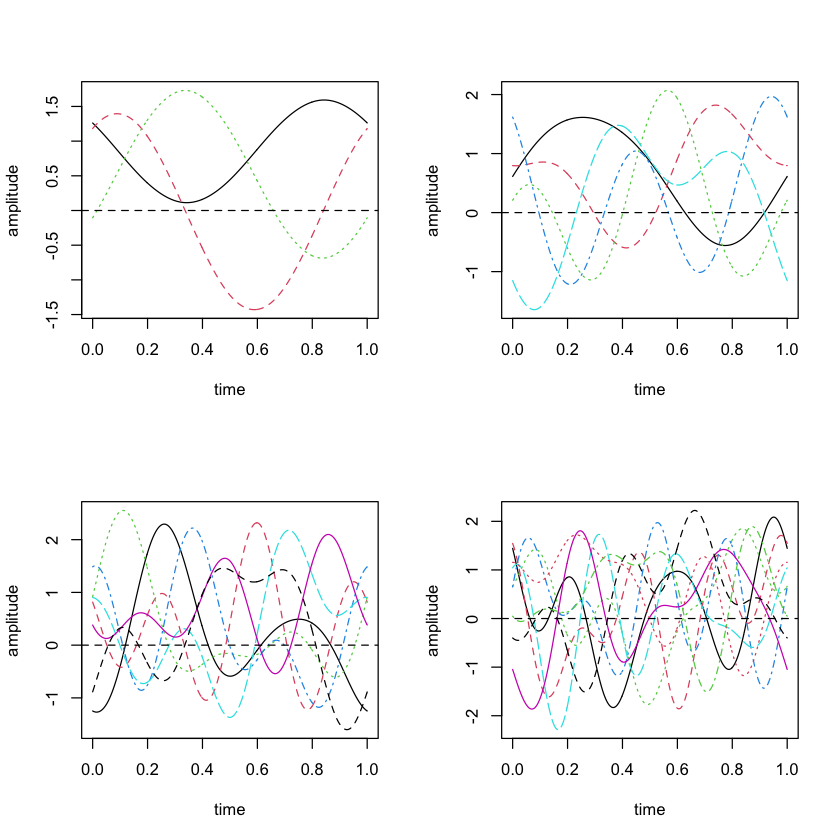

In [6]:
par(bg="white", mfrow=c(2,2))
for(m in 1:M){    

    plot(fbasis_list[[m]], xlab="time", ylab="amplitude",
        sub=paste("Estimated functional basis of data modaltiy", m))
}

[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"
[1] "Esimtating funcational basis of data modality 3"
[1] "Esimtating funcational basis of data modality 4"


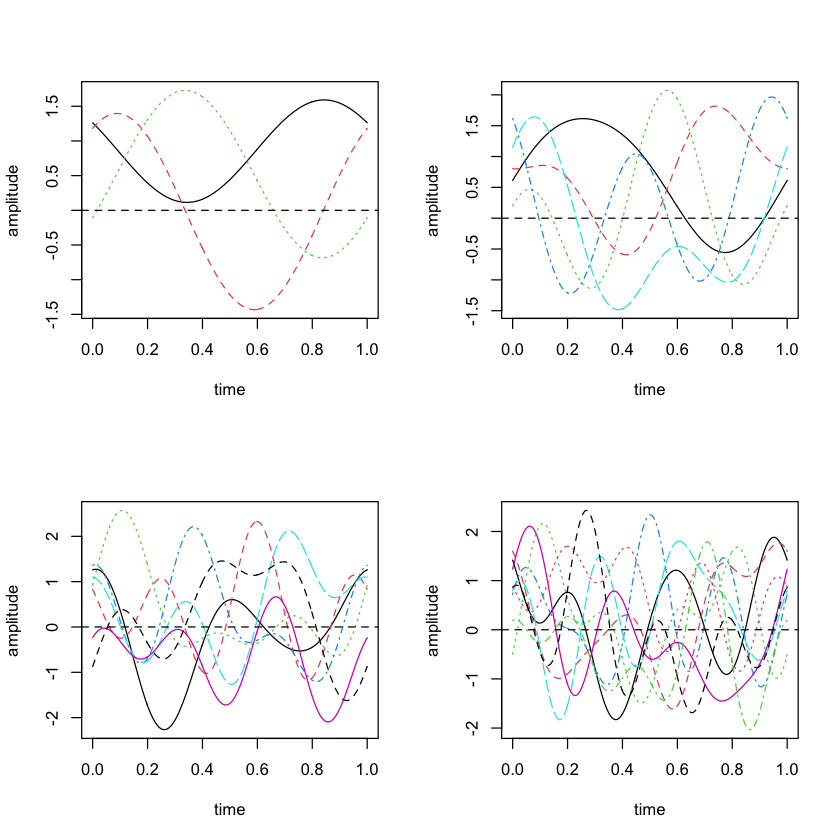

In [7]:
fbasis2_list <- list()
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    fbasis2_list[[m]] <- estimate.fpca.basis.fourier(c(0,1), obs.time, t(data_mean[[m]]), km1[m], bs.nbasis=km1[m]*2)
}
par(bg="white", mfrow=c(2,2))
for(m in 1:M){
    plot(fbasis2_list[[m]], xlab="time", ylab="amplitude", 
        sub=paste("Estimated functional basis of data modaltiy", m))
}

[1] 1
[1] 1.0000653 0.9997581 1.0002015
[1] 2
[1]  0.9999968  0.9999782  0.9999937  0.9998857 -1.0001092
[1] 3
[1] -0.9991575  0.9971198  0.9973589  0.9915744  0.9902708 -0.9965378  0.9995652
[1] 4
[1]  0.9847452  0.7857669  0.7523224  0.8785699  0.8908873 -0.9372207 -0.8642298
[8]  0.9372417 -0.9761051


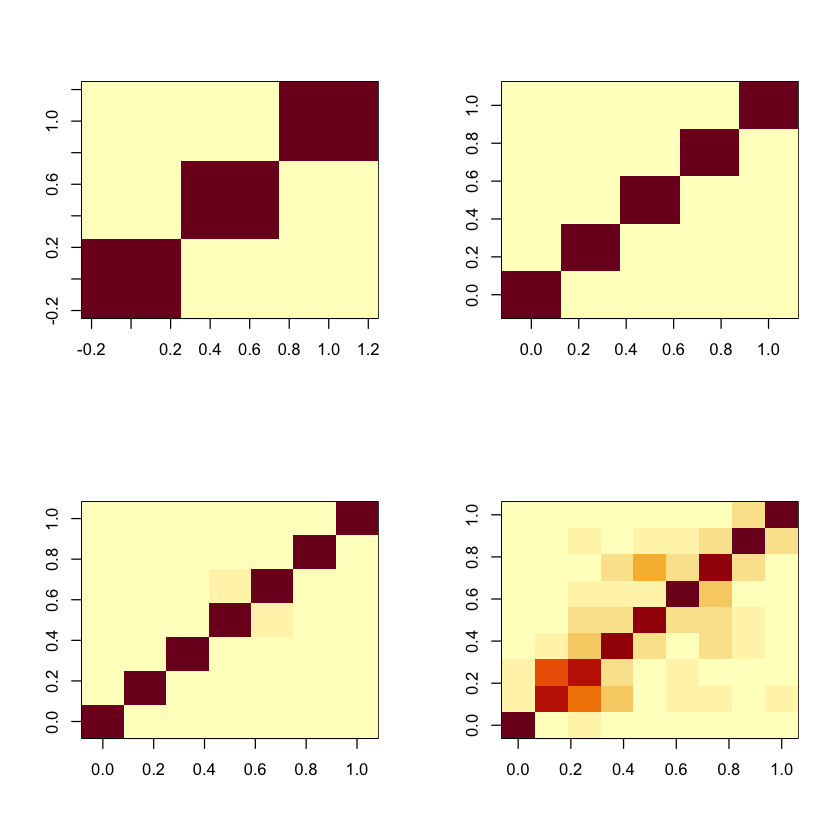

In [8]:
##compare the difference of using fourier basis and bspline basis
par(bg="white", mfrow=c(2,2))
for(m in 1:M){
    print(m)
    image(abs(inprod(fbasis2_list[[m]], fbasis_list[[m]])))
    print(diag(inprod(fbasis2_list[[m]], fbasis_list[[m]])))
}
